## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명: 딥러닝 응용
- 평가일: 5월 20일
- 성명: 김기현
- 점수: 100점

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Q1. mnist datasets를 불러와서 PyTorch 프레임워크으로 다음을 수행하세요.
---
- 생성자 및 판별자 클래스 정의 및 학습데이터 불러오기
- 모델 학습 및 샘플링
 - 학습을 위한 생성자와 판매자 모델 초기화
 - 적절한 하이퍼 파라미터 설정(lr = 0.0002, betas=(0.5, 0.999))
 - 모델을 학습하면서 주기적으로 샘플링하여 결과 확인(n_epochs = 200, sample_interval = 2000)
- 생성된 이미지(5x5) 예시 출력 

정답

In [59]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [60]:
transforms_train = transforms.Compose([transforms.Resize(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5], [0.5])
                                       ])

train_dataset = datasets.MNIST(root="./dataset", train = True, download = True, transform = transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 4)

## # 생성자
---

In [61]:
latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_dim, output_dim, normalize = True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8)) # 배치 정규화 수행(차원 동일)
            layers.append(nn.LeakyReLU(0.2, inplace = True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록
        self.model = nn.Sequential(*block(latent_dim, 128, normalize = False),
                                   *block(128, 256),
                                   *block(256, 512),
                                   *block(512, 1024),
                                   nn.Linear(1024, 1 * 28 * 28),
                                   nn.Tanh()
                                   )
        
    def forward(self, z):
        img = self.model(z) # 노이즈 벡터 z

        # 이미지 형태로 만들어 줌
        img = img.view(img.size(0), 1, 28, 28) # 배치 사이즈, 채널, 넓이, 높이
        return img

## # 판별자
---

In [62]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(nn.Linear(1 * 28 * 28, 512),
                                   nn.LeakyReLU(0.2, inplace = True),
                                   nn.Linear(512, 256),
                                   nn.LeakyReLU(0.2, inplace = True),
                                   nn.Linear(256, 1),
                                   nn.Sigmoid(), # 확률값을 내보냄
                                   )
        
    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)
        return output

## # 손실함수, 옵티마이저
---

In [63]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실함수
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 옵티마이저 (최적화 함수)
lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))

## # 모델 훈련
---

In [64]:
import time

n_epochs = 200
sample_interval = 2000 # 몇 번의 배치마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜 이미지와 가짜 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real) : 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake) : 0

        real_imgs = imgs.cuda()

        # 생성자 학습
        optimizer_G.zero_grad()

        # 랜덤 노이즈 샘플링
        z = torch.normal(mean = 0, std = 1, size = (imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자의 손실 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자 업데이트
        g_loss.backward()
        optimizer_G.step()

        # 판별자 학습
        optimizer_D.zero_grad()

        # 판별자 손실 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:

            # 생성된 이미지 중에서 25개만 선택하여 5x5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f'{done:05d}.png', nrow = 5, normalize = True)

    # 하나의 epoch이 끝날 때마다 로그 출력
    print(f'[Epoch {epoch}/{n_epochs}] [D loss : {d_loss.item():.6f}] [G loss : {g_loss.item():.6f}] [Elapsed time : {time.time() - start_time:.2f}s]')

[Epoch 0/200] [D loss : 0.499887] [G loss : 0.854861] [Elapsed time : 9.25s]
[Epoch 1/200] [D loss : 0.497002] [G loss : 1.803979] [Elapsed time : 18.57s]
[Epoch 2/200] [D loss : 0.564748] [G loss : 0.650984] [Elapsed time : 27.88s]
[Epoch 3/200] [D loss : 0.343962] [G loss : 1.180583] [Elapsed time : 37.11s]
[Epoch 4/200] [D loss : 0.226683] [G loss : 1.519389] [Elapsed time : 46.38s]
[Epoch 5/200] [D loss : 0.382315] [G loss : 0.864768] [Elapsed time : 55.74s]
[Epoch 6/200] [D loss : 0.352575] [G loss : 1.751308] [Elapsed time : 65.01s]
[Epoch 7/200] [D loss : 0.387771] [G loss : 3.273668] [Elapsed time : 74.26s]
[Epoch 8/200] [D loss : 0.359710] [G loss : 1.175037] [Elapsed time : 83.53s]
[Epoch 9/200] [D loss : 0.227533] [G loss : 1.657626] [Elapsed time : 92.69s]
[Epoch 10/200] [D loss : 0.222015] [G loss : 3.561543] [Elapsed time : 101.90s]
[Epoch 11/200] [D loss : 0.270163] [G loss : 1.018107] [Elapsed time : 111.14s]
[Epoch 12/200] [D loss : 0.282695] [G loss : 1.175200] [Elaps

## # GIF 생성
---

In [1]:
!pip install IPython==6.2.0

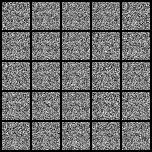

In [2]:
import imageio
import glob
from IPython import display
import matplotlib.pyplot as plt
from PIL import Image

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

display.Image(filename=anim_file, width = 300, height = 300)

# Q2. 아래사항을 참조하여 로드된 ECG 데이터를 활용하여 이상치 감지 모델을 만든 후 성능 평가를 수행하세요.
---
[ECG5000 데이터세트]에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도]가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

정답

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, Conv2DTranspose
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
# Download the dataset
import pandas as pd
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## # 데이터 전처리
---

In [7]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 21)

# 정규화 - 전체 데이터 기준으로 MinMaxScaler(0, 1)
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# 레이블이 1로 지정된 정상 리듬만 사용하여 오토인코더를 훈련
# 정상 리듬과 비정상 리듬을 분리
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

## # 모델 훈련
---

In [8]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([Dense(32, activation="relu"),
                                            Dense(16, activation="relu"),
                                            Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([Dense(16, activation="relu"),
                                            Dense(32, activation="relu"),
                                            Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs = 20, 
          batch_size = 512,
          validation_data = (test_data, test_data),
          shuffle = True)

Epoch 1/20
5/5 [==============================] - 2s 62ms/step - loss: 0.0577 - val_loss: 0.0532
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0557 - val_loss: 0.0513
Epoch 3/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0527 - val_loss: 0.0495
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0490 - val_loss: 0.0479
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0454 - val_loss: 0.0455
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0419 - val_loss: 0.0440
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0388 - val_loss: 0.0422
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0358 - val_loss: 0.0412
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0332 - val_loss: 0.0397
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0311 - val_loss: 0.0390
Epoch 11/20
5/5 [=============

## # 재구성 오류 시각화
---

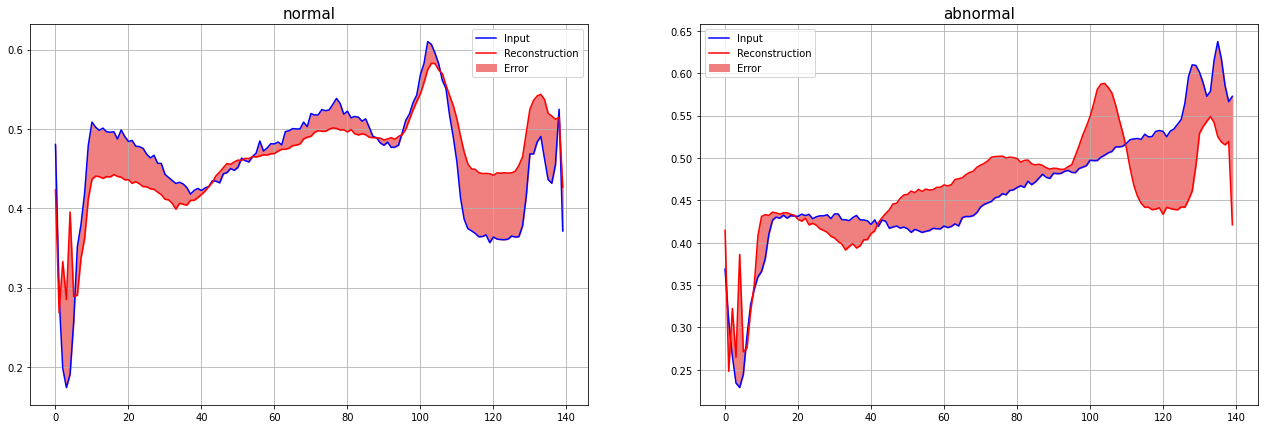

In [14]:
fig = plt.figure(figsize = (22, 7))

# 정상 ECG
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

fig.add_subplot(1, 2, 1)
plt.grid()
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title('normal', fontsize = 15)

# 비정상 ECG
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

fig.add_subplot(1, 2, 2)
plt.grid()
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title('abnormal', fontsize = 15)

plt.show()

## # 이상 감지
---

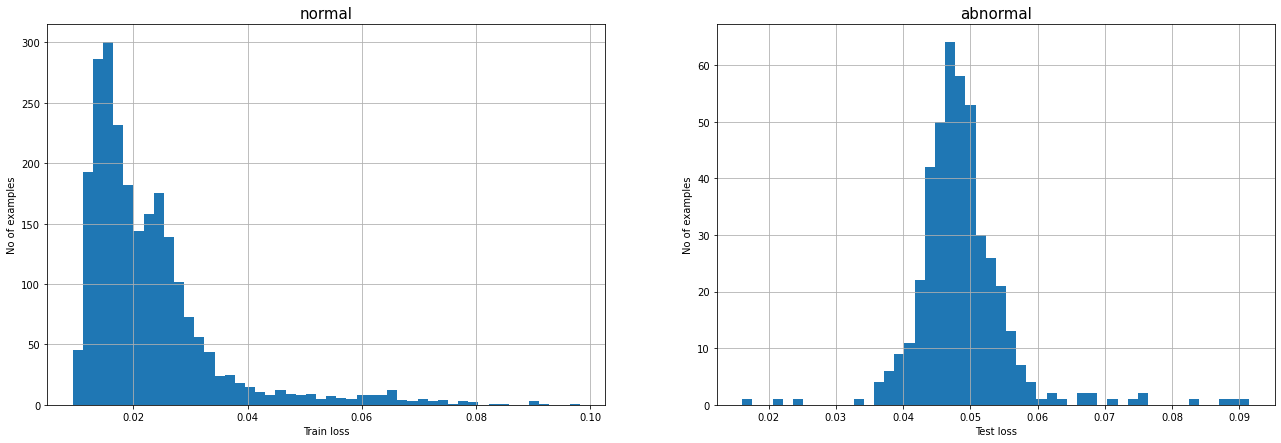

In [15]:
fig = plt.figure(figsize = (22, 7))

# 정상 ECG에 대한 재구성 오류를 시각화
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

fig.add_subplot(1, 2, 1)
plt.grid()
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.title('normal', fontsize = 15)

# 비정상 ECG에 대한 재구성 오류를 시각화
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

fig.add_subplot(1, 2, 2)
plt.grid()
plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.title('abnormal', fontsize = 15)

plt.show()

In [16]:
# 평균보다 표준 편차가 높은 임계값을 선택

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.034315057


In [17]:
# 재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.942
Precision = 0.9921568627450981
Recall = 0.9035714285714286


# Q3. YOLOv5를 활용하고 포트홀 데이터로 파인튜닝하여 "포트홀 탐지모델"을 개발하고 테스트 데이터 샘플에 대하여 포트홀 탐지가 되는지 확인하세요.
---
YOLOv5 : https://github.com/ultralytics/yolov5.git<br>
포트홀 데이터 : https://public.roboflow.com/object-detection/pothole

정답

## # YOLOv5 작업환경 구성
---

In [22]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import yaml
import glob
from IPython.display import Image, clear_output
from IPython.core.magic import register_line_cell_magic

/content
fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [23]:
%mkdir /content/yolov5/pothole
%cd /content/yolov5/pothole

/content/yolov5/pothole


## # 데이터 불러오기
---

In [24]:
# curl 데이터 전송 도구 . -L 옵션을 사용하여 HTTP 위치 헤더를 따르기(리디렉션을 따르도록 curl을 사용할 수 있음)
!curl -L "https://public.roboflow.com/ds/NPBjcSbM9x?key=GpRStn0j1F" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# 훈련, 검증, 테스트 셋 만들기
from glob import glob

train_img_list = glob('/content/yolov5/pothole/train/images/*.jpg')
test_img_list = glob('/content/yolov5/pothole/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/pothole/test/images/*.jpg')

print(len(train_img_list), len(test_img_list), len(valid_img_list))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1931      0 --:--:-- --:--:-- --:--:--  1931
100 46.0M  100 46.0M    0     0  58.2M      0 --:--:-- --:--:-- --:--:-- 58.2M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting: test/images/img

In [31]:
with open('/content/yolov5/pothole/train.txt', 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')

with open('/content/yolov5/pothole/test.txt', 'w') as f:
    f.write('\n'.join(test_img_list) + '\n')

with open('/content/yolov5/pothole/valid.txt', 'w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

In [32]:
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [33]:
%cat /content/yolov5/pothole/data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['pothole']

In [34]:
# data.yaml 디렉토리 수정

%%writetemplate /content/yolov5/pothole/data.yaml

train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [35]:
%cat /content/yolov5/pothole/data.yaml


train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

## # 모델 구성
---

In [37]:
num_classes = 1

In [38]:
# 수정된 모델 생성

%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [39]:
%cat /content/yolov5/models/custom_yolov5s.yaml


# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [40]:
# 모델 학습 및 검증

%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 32 --epochs 100 --data ./pothole/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name pothole_results --cache

!python val.py --weights runs/train/pothole_results/weights/best.pt --data ./pothole/data.yaml --img 640 --task test

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./pothole/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=pothole_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, ancho

In [45]:
!python val.py --weights runs/train/pothole_results2/weights/best.pt --data ./pothole/data.yaml --img 640 --task test

val: data=./pothole/data.yaml, weights=['runs/train/pothole_results2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/content/yolov5/pothole/test/labels' images and labels...67 found, 0 missing, 0 empty, 0 corrupt: 100% 67/67 [00:00<00:00, 2020.71it/s]
test: New cache created: /content/yolov5/pothole/test/labels.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00:02<00:00,  1.36it/s]
                 all         67        154      0.784      0.684      0.751      0.368
Speed: 1.2m

## # 객체 탐지 시행
---

In [46]:
# 학습된 모델로 객체 탐지 시행

!python detect.py --weights runs/train/pothole_results2/weights/best.pt --img 640 --conf 0.4 --source ./pothole/test/images

detect: weights=['runs/train/pothole_results2/weights/best.pt'], source=./pothole/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/67 /content/yolov5/pothole/test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg: 640x640 1 pothole, Done. (0.011s)
image 2/67 /content/yolov5/pothole/test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg: 640x640 1 pothole, Done. (0.014s)
image 3/67 /content/yolov5/pothole/test/images/img-146_jp

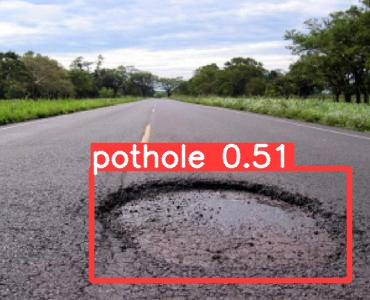

In [51]:
# 객체 탐지 결과물 시각화

import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp4/*.jpg'))
display(Image(filename = image_name))

# Q4~5. 주어진 네이버 댓글 데이터 ratings_train.txt, ratings_test.txt 를 활용하여 아래 요구사항에 따라 감성분석 모델 생성 및 평가를 수행하세요.
---
- pre-trained model로 kobert 사용
- pre-trained model로 bert multilingual 사용

정답
정답

In [13]:
!pip install transformers
!pip install sentencepiece
!pip install sacremoses
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os
import re
import sentencepiece as spm
from tokenization_kobert import KoBertTokenizer

In [7]:
import sys
sys.path.append("/content/drive/MyDrive/workspace/cakd5/m10_딥러닝 응용/고급 자연어 처리")

In [6]:
!git clone https://github.com/e9t/nsmc.git

train = pd.read_table('nsmc/' + 'ratings_train.txt')
test = pd.read_table('nsmc/' + 'ratings_test.txt')

train.head()

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [19]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 64 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, pad_to_max_length=True)
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN
 
        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(긍정 : 1 부정 0)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])
 
    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)
 
    return [tokens, masks, segments], targets
 
# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y
 
SEQ_LEN = 64
BATCH_SIZE = 32

# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "document"

# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "label"

In [20]:
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)

  0%|          | 0/150000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 50000/50000 [00:13<00:00, 3627.01it/s]


## # kobert
---

In [36]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

import tensorflow_addons as tfa

# 총 batch size * 4 epoch = 2344 * 4
opt = tfa.optimizers.RectifiedAdam(learning_rate = 5.0e-5, 
                                   total_steps = 2344 * 4,
                                   warmup_proportion = 0.1, 
                                   min_lr = 1e-5,
                                   epsilon = 1e-08,
                                   clipnorm = 1.0)

loading file https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model from cache at /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
loading file https://huggingface.co/monologg/kobert/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
loading file https://huggingface.co/monologg/kobert/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/monologg/kobert/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/monologg/kobert/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e8525

In [37]:
model = TFBertModel.from_pretrained('monologg/kobert', from_pt = True)

# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name = 'input_segment')

# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
bert_outputs = bert_outputs[1]

sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_outputs)
sentiment_first = tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
sentiment_model.compile(optimizer = opt, 
                        loss=tf.keras.losses.BinaryCrossentropy(), 
                        metrics = ['accuracy'])

sentiment_model.fit(train_x, train_y, 
                    epochs = 2, 
                    shuffle = True, batch_size = 64,
                    validation_split = 0.1)

loading configuration file https://huggingface.co/monologg/kobert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

loading weights file https://huggingface.co/monologg/kobert/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9525d

Epoch 1/2
2110/2110 [==============================] - 1134s 521ms/step - loss: 0.4038 - accuracy: 0.7958 - val_loss: 0.2876 - val_accuracy: 0.8784
Epoch 2/2
2110/2110 [==============================] - 1095s 519ms/step - loss: 0.2522 - accuracy: 0.8982 - val_loss: 0.2566 - val_accuracy: 0.8965


In [38]:
sentiment_model.evaluate(test_x, test_y)

1563/1563 [==============================] - 157s 101ms/step - loss: 0.2673 - accuracy: 0.8926


[0.2672734260559082, 0.8925600051879883]

## # bert
---

In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

import tensorflow_addons as tfa

# 총 batch size * 4 epoch = 2344 * 4
opt = tfa.optimizers.RectifiedAdam(learning_rate = 5.0e-5, 
                                   total_steps = 2344 * 4,
                                   warmup_proportion = 0.1, 
                                   min_lr = 1e-5,
                                   epsilon = 1e-08,
                                   clipnorm = 1.0)

https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpv6124oy0


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
creating metadata file for /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmplcd95xmu


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
creating metadata file for /root/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://hug

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
creating metadata file for /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidde

In [57]:
# model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = 2)
model = TFBertModel.from_pretrained('bert-base-multilingual-cased', from_pt = True)

# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name = 'input_segment')

# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
bert_outputs = bert_outputs[1]

sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_outputs)
sentiment_first = tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
sentiment_model.compile(optimizer = opt, 
                        loss=tf.keras.losses.BinaryCrossentropy(), 
                        metrics = ['accuracy'])

sentiment_model.fit(train_x, train_y, 
                    epochs = 2, 
                    shuffle = True, batch_size = 64,
                    validation_split = 0.1)

loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type

Epoch 1/2
2110/2110 [==============================] - 1181s 542ms/step - loss: 0.5026 - accuracy: 0.7288 - val_loss: 0.3788 - val_accuracy: 0.8264
Epoch 2/2
2110/2110 [==============================] - 1141s 541ms/step - loss: 0.3498 - accuracy: 0.8461 - val_loss: 0.3433 - val_accuracy: 0.8605


In [58]:
sentiment_model.evaluate(test_x, test_y)

1563/1563 [==============================] - 158s 101ms/step - loss: 0.3605 - accuracy: 0.8513


[0.3605295419692993, 0.8513000011444092]